#Olivetti face データセットを用いた顔認識

## データセットのインポート

In [8]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [0]:
X = dataset.data
y = dataset.target

In [0]:
import numpy as np
np.random.seed(21)
idx_rand = np.random.randint(len(X), size=8)

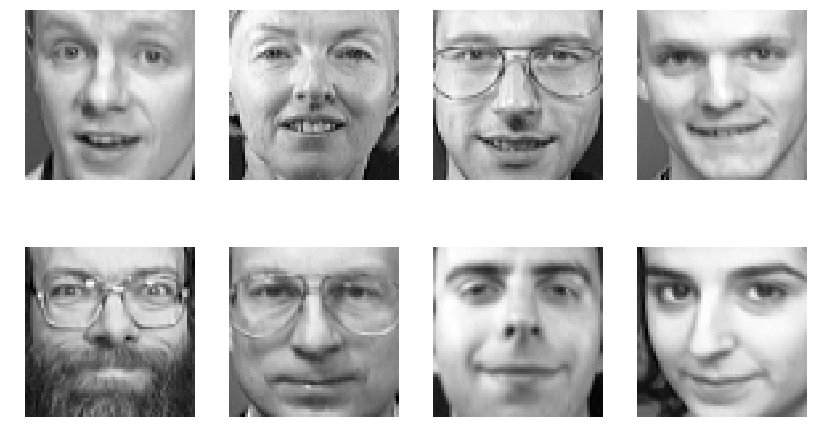

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 8))
for p, i in enumerate(idx_rand):
    plt.subplot(2, 4, p + 1)
    plt.imshow(X[i, :].reshape((64, 64)), cmap='gray')
    plt.axis('off')

## データセットの前処理

In [0]:
n_samples, n_features = X.shape
X -= X.mean(axis=0)

In [0]:
X -= X.mean(axis=1).reshape(n_samples, -1)

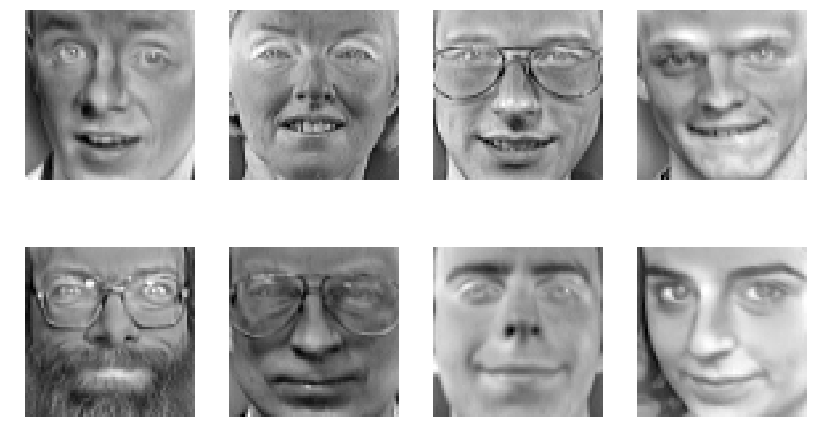

In [0]:
plt.figure(figsize=(14, 8))
for p, i in enumerate(idx_rand):
    plt.subplot(2, 4, p + 1)
    plt.imshow(X[i, :].reshape((64, 64)), cmap='gray')
    plt.axis('off')
plt.savefig('olivetti-pre.png')

## ランダムフォレストを用いて学習・テストする

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=21
)

In [0]:
import cv2
rtree = cv2.ml.RTrees_create()

In [0]:
num_trees = 50
eps = 0.01
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            num_trees, eps)
rtree.setTermCriteria(criteria)

In [0]:
rtree.setMaxCategories(len(np.unique(y)))

In [0]:
rtree.setMinSampleCount(2)

In [0]:
rtree.setMaxDepth(1000)

In [0]:
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [0]:
rtree.getMaxDepth()

25

In [0]:
_, y_hat = rtree.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat)

0.87

In [0]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=21, max_depth=25)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

In [0]:
num_trees = 100
eps = 0.01
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            num_trees, eps)
rtree.setTermCriteria(criteria)
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train);
_, y_hat = rtree.predict(X_test)
accuracy_score(y_test, y_hat)

# CNNを用いたOlivetti faceデータセットの分類

In [1]:
import numpy as np
import keras

from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(64, 64, 1))) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten()) 
model.add(Dense(120, activation='relu',
                kernel_initializer='he_normal')) 
model.add(Dense(84, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(40, activation='softmax')) 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=21
)

In [0]:
X_train =  X_train.reshape(-1, 64, 64, 1)
X_test =  X_test.reshape(-1, 64, 64, 1)

In [0]:
y_train = np.eye(40)[y_train.astype('int32').flatten()]
y_test = np.eye(40)[y_test.astype('int32').flatten()]

In [15]:
X_train.shape

(300, 64, 64, 1)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=21
)

In [0]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
epochs = 100
batch_sizes = 128

early_stopping = EarlyStopping(patience=1, verbose=1)
result = model.fit(x=X_train, y=y_train, batch_size=batch_sizes, epochs=epochs, verbose=1,
          validation_data=(X_valid, y_valid))

Train on 225 samples, validate on 75 samples
Epoch 1/100
225/225 [==============================] - 0s 183us/step - loss: 7.5651e-04 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.8667
Epoch 2/100
225/225 [==============================] - 0s 182us/step - loss: 7.5006e-04 - acc: 1.0000 - val_loss: 0.6889 - val_acc: 0.8667
Epoch 3/100
225/225 [==============================] - 0s 180us/step - loss: 7.4766e-04 - acc: 1.0000 - val_loss: 0.6885 - val_acc: 0.8667
Epoch 4/100
225/225 [==============================] - 0s 170us/step - loss: 7.4011e-04 - acc: 1.0000 - val_loss: 0.6880 - val_acc: 0.8667
Epoch 5/100
225/225 [==============================] - 0s 167us/step - loss: 7.3457e-04 - acc: 1.0000 - val_loss: 0.6881 - val_acc: 0.8667
Epoch 6/100
225/225 [==============================] - 0s 175us/step - loss: 7.2935e-04 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.8667
Epoch 7/100
225/225 [==============================] - 0s 172us/step - loss: 7.2441e-04 - acc: 1.0000 - val_loss: 0.6904 

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6392848030477762
Test accuracy: 0.86


In [33]:
# ヒストリデータのラベルを見てみる
result.history.keys() 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

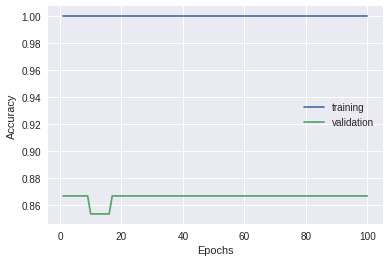

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(range(1, epochs+1), result.history['acc'], label="training")
plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    width_shift_range=0,   # 左右にずらす
    height_shift_range=0,  # 上下にずらす
    horizontal_flip=False,  # 左右反転
    samplewise_center=True,
    samplewise_std_normalization=True,
    zca_whitening=False)

In [39]:
epochs = 100
batch_sizes = 128

early_stopping = EarlyStopping(patience=1, verbose=1)
result = model.fit(x=X_train, y=y_train, batch_size=batch_sizes, epochs=epochs, verbose=1,
          validation_data=(X_valid, y_valid))

Train on 225 samples, validate on 75 samples
Epoch 1/100
225/225 [==============================] - 0s 188us/step - loss: 1.6627e-04 - acc: 1.0000 - val_loss: 0.7434 - val_acc: 0.8667
Epoch 2/100
225/225 [==============================] - 0s 170us/step - loss: 1.6561e-04 - acc: 1.0000 - val_loss: 0.7434 - val_acc: 0.8667
Epoch 3/100
225/225 [==============================] - 0s 169us/step - loss: 1.6492e-04 - acc: 1.0000 - val_loss: 0.7431 - val_acc: 0.8667
Epoch 4/100
225/225 [==============================] - 0s 175us/step - loss: 1.6438e-04 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 0.8667
Epoch 5/100
225/225 [==============================] - 0s 175us/step - loss: 1.6371e-04 - acc: 1.0000 - val_loss: 0.7423 - val_acc: 0.8667
Epoch 6/100
225/225 [==============================] - 0s 175us/step - loss: 1.6309e-04 - acc: 1.0000 - val_loss: 0.7420 - val_acc: 0.8667
Epoch 7/100
225/225 [==============================] - 0s 171us/step - loss: 1.6256e-04 - acc: 1.0000 - val_loss: 0.7420 

In [47]:
epochs = 100
batch_sizes = 128

model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_sizes),
                    epochs=epochs, workers=0, validation_data=(X_valid, y_valid))

ValueError: ignored

In [41]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6669568247720599
Test accuracy: 0.85


In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal',strides=(2,2), input_shape=(64, 64, 1))) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) 
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1),activation='relu',
                 kernel_initializer='he_normal'))  
model.add(Flatten()) 
model.add(Dense(1024, activation='relu',
                kernel_initializer='he_normal')) 
model.add(Dense(1024, activation='relu',
                kernel_initializer='he_normal')) 
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='softmax')) 

In [0]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

In [55]:
epochs = 10
batch_sizes = 128

early_stopping = EarlyStopping(patience=1, verbose=1)
result = model.fit(x=X_train, y=y_train, batch_size=batch_sizes, epochs=epochs, verbose=1,
          validation_data=(X_valid, y_valid))

Train on 225 samples, validate on 75 samples
Epoch 1/10
225/225 [==============================] - 0s 397us/step - loss: 1.0078e-04 - acc: 1.0000 - val_loss: 0.3788 - val_acc: 0.9200
Epoch 2/10
225/225 [==============================] - 0s 387us/step - loss: 0.0042 - acc: 0.9956 - val_loss: 0.3765 - val_acc: 0.9200
Epoch 3/10
225/225 [==============================] - 0s 379us/step - loss: 1.0972e-04 - acc: 1.0000 - val_loss: 0.3732 - val_acc: 0.9200
Epoch 4/10
225/225 [==============================] - 0s 359us/step - loss: 2.5761e-04 - acc: 1.0000 - val_loss: 0.3742 - val_acc: 0.9200
Epoch 5/10
225/225 [==============================] - 0s 345us/step - loss: 1.8339e-04 - acc: 1.0000 - val_loss: 0.3777 - val_acc: 0.9200
Epoch 6/10
225/225 [==============================] - 0s 336us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3803 - val_acc: 0.9067
Epoch 7/10
225/225 [==============================] - 0s 348us/step - loss: 4.2802e-04 - acc: 1.0000 - val_loss: 0.3833 - val_acc: 0.90

In [56]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6567748811841011
Test accuracy: 0.89


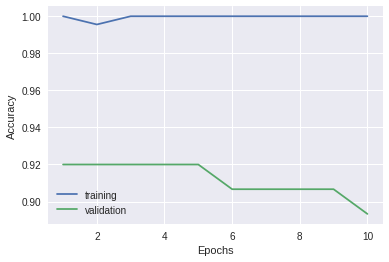

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(range(1, epochs+1), result.history['acc'], label="training")
plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()